In [115]:
%logstop
%logstart -rtq ~/.logs/nlp.py append
import seaborn as sns
sns.set()

In [2]:
from static_grader import grader

# NLP Miniproject

## Introduction

The objective of this miniproject is to gain experience with natural language processing and how to use text data to train a machine learning model to make predictions. For the miniproject, we will be working with product review text from Amazon. The reviews are for only products in the "Electronics" category. The objective is to train a model to predict the rating, ranging from 1 to 5 stars.

## Scoring

For most of the questions, you will be asked to submit the `predict` method of your trained model to the grader. The grader will use the passed `predict` method to evaluate how your model performs on a test set with respect to a reference model. The grader uses the [R<sup>2</sup>-score](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score) for model evaluation. If your model performs better than the reference solution, then you can score higher than 1.0. For the last question, you will submit the results of an analysis and your passed answer will be compared directly to the reference solution.

## Downloading and loading the data

The data set is available on Amazon S3 and comes as a compressed file where each line is a JSON object. To load the data set, we will need to use the `gzip` library to open the file and decode each JSON into a Python dictionary. In the end, we have a list of dictionaries, where each dictionary represents an observation.

In [4]:
%%bash
mkdir data
wget http://dataincubator-wqu.s3.amazonaws.com/mldata/amazon_electronics_reviews_training.json.gz -nc -P ./data

mkdir: cannot create directory ‘data’: File exists
File ‘./data/amazon_electronics_reviews_training.json.gz’ already there; not retrieving.



In [5]:
import gzip
import simplejson as json

with gzip.open("data/amazon_electronics_reviews_training.json.gz", "r") as f:                                  
    data = [json.loads(line) for line in f]

The ratings are stored in the keyword `"overall"`. You should create an array of the ratings for each review, preferably using list comprehensions.

In [6]:
data[0]

{'reviewerID': 'A238V1XTSK9NFE',
 'asin': 'B00004VX3T',
 'reviewerName': 'Andrew Lynn',
 'helpful': [2, 2],
 'reviewText': "I bought this mouse to use with my laptop because I don't like those little touchpads.  I could not be happier.Since it's USB, I can plug it in with the computer already on and expect it to work automatically.  Since it's optical (the new kind, not to be confused with the old Sun optical mice that required a special checkered mouse pad) it works on most surfaces, including my pant legs, my couch, and random tables that I put my laptop down on.  It's also light and durable, features that help with portability.The wheel is surprisingly useful.  In addition to scrolling, it controls zoom and pan in programs like Autocad and 3D Studio Max.  I can no longer bear using either of these programs without it.One complaint - the software included with the Internet navigation features is useless.  Don't bother installing it if you have a newer Windows version that automatical

In [6]:
ratings =[row['overall'] for row in data]
ratings[0]

5.0

In [13]:
set(ratings)

{1.0, 2.0, 3.0, 4.0, 5.0}

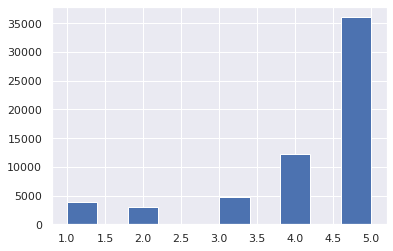

In [11]:
import matplotlib.pyplot as plt
plt.hist(ratings);

**Note**, the test set used by the grader is in the same format as that of `data`, a list of dictionaries. Your trained model needs to accept data in the same format. Thus, you should use `Pipeline` when constructing your model so that all necessary transformation needed are encapsulated into a single estimator object.

## Question 1: Bag of words model

Construct a machine learning model trained on word counts using the bag of words algorithm. Remember, the bag of words is implemented with `CountVectorizer`. Some things you should consider:

* The reference solution uses a linear model and you should as well; use either `Ridge` or `SGDRegressor`.
* The text review is stored in the key `"reviewText"`. You will need to construct a custom transformer to extract out the value of this key. It will be the first step in your pipeline.
* Consider what hyperparameters you will need to tune for your model.
* Subsampling the training data will boost training times, which will be helpful when determining the best hyperparameters to use. Note, your final model will perform best if it is trained on the full data set.
* Including stop words may help with performance.

In [7]:
from sklearn.base import BaseEstimator,TransformerMixin
class KeySelector(BaseEstimator,TransformerMixin):
    def __init__(self,key):
        self.key=key
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return [row['reviewText'] for row in X]

In [25]:
KeySelector('reviewText').fit_transform(data)[:5]

["I bought this mouse to use with my laptop because I don't like those little touchpads.  I could not be happier.Since it's USB, I can plug it in with the computer already on and expect it to work automatically.  Since it's optical (the new kind, not to be confused with the old Sun optical mice that required a special checkered mouse pad) it works on most surfaces, including my pant legs, my couch, and random tables that I put my laptop down on.  It's also light and durable, features that help with portability.The wheel is surprisingly useful.  In addition to scrolling, it controls zoom and pan in programs like Autocad and 3D Studio Max.  I can no longer bear using either of these programs without it.One complaint - the software included with the Internet navigation features is useless.  Don't bother installing it if you have a newer Windows version that automatically supports wheel mice.  Just plug it in and use it - it's that easy.",
 'One by one, all of the discs went bad within a 6

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
bag_of_words_model =Pipeline([
    ('selector',KeySelector('reviewText')),
    ('vectorised',CountVectorizer()),
    
    ('regressor',Ridge(alpha=100)),
    
])

In [10]:
bag_of_words_model.fit(data,ratings)

Pipeline(steps=[('selector', KeySelector(key='reviewText')),
                ('vectorised', CountVectorizer()),
                ('regressor', Ridge(alpha=100))])

In [11]:
grader.score.nlp__bag_of_words_model(bag_of_words_model.predict)

Your score: 1.031


## Question 2: Normalized model

Using raw counts will not be as effective compared if we had normalized the counts. There are several ways to normalize raw counts; the `HashingVectorizer` class has the keyword `norm` and there is also the `TfidfTransformer` and `TfidfVectorizer` that perform tf-idf weighting on the counts. Apply normalization to your model to improve performance.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

normalized_model = Pipeline([
    ('selector',KeySelector('reviewText')),
    ('vectorised',TfidfVectorizer()),
    
    ('regressor',Ridge(alpha=1)),
    
])
normalized_model.fit(data,ratings)

Pipeline(steps=[('selector', KeySelector(key='reviewText')),
                ('vectorised', TfidfVectorizer()),
                ('regressor', Ridge(alpha=1))])

In [15]:
grader.score.nlp__normalized_model(normalized_model.predict)

Your score: 1.059


## Question 3: Bigrams model

The model performance may increase when including additional features generated by counting bigrams. Include bigrams to your model. When using more features, the risk of overfitting increases. Make sure you try to minimize overfitting as much as possible.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
TfidfVectorizer()

TfidfVectorizer()

In [17]:

bigrams_model =Pipeline([
    ('selector',KeySelector('reviewText')),
    ('vectorised',TfidfVectorizer(ngram_range=(1,2))),
    
    ('regressor',Ridge(alpha=1)),
    
])
bigrams_model.fit(data,ratings)

Pipeline(steps=[('selector', KeySelector(key='reviewText')),
                ('vectorised', TfidfVectorizer(ngram_range=(1, 2))),
                ('regressor', Ridge(alpha=1))])

In [18]:
grader.score.nlp__bigrams_model(bigrams_model.predict)

Your score: 1.179


## Question 4: Polarity analysis

Let's derive some insight from our analysis. We want to determine the most polarizing words in the corpus of reviews. In other words, we want identify words that strongly signal a review is either positive or negative. For example, we understand a word like "terrible" will mostly appear in negative rather than positive reviews. The naive Bayes model calculates probabilities such as $P(\text{terrible } | \text{ negative})$, the probability the word "terrible" appears in the text, given that the review is negative. Using these probabilities, we can derive a **polarity score** for each counted word,

$$
\text{polarity} =  \log\left(\frac{P(\text{word } | \text{ positive})}{P(\text{word } | \text{ negative})}\right).
$$ 

The polarity analysis is an example where a simpler model offers more explicability than a more complicated model. For this question, you are asked to determine the top twenty-five words with the largest positive **and** largest negative polarity, for a total of fifty words. For this analysis, you should:

1. Use the naive Bayes model, `MultinomialNB`.
1. Use tf-idf weighting.
1. Remove stop words.

A trained naive Bayes model stores the log of the probabilities in the attribute `feature_log_prob_`. It is a NumPy array of shape (number of classes, the number of features). You will need the mapping between feature index to word. For this problem, you will use a different data set; it has been processed to only include reviews with one and five stars. You can download it below.

In [8]:
%%bash
wget http://dataincubator-wqu.s3.amazonaws.com/mldata/amazon_one_and_five_star_reviews.json.gz -nc -P ./data

File ‘./data/amazon_one_and_five_star_reviews.json.gz’ already there; not retrieving.



In order to avoid memory issues, let's delete the older data.

In [39]:
whos

Variable             Type        Data/Info
------------------------------------------
BaseEstimator        type        <class 'sklearn.base.BaseEstimator'>
CountVectorizer      type        <class 'sklearn.feature_e<...>on.text.CountVectorizer'>
HashingVectorizer    type        <class 'sklearn.feature_e<...>.text.HashingVectorizer'>
KeySelector          type        <class '__main__.KeySelector'>
Pipeline             ABCMeta     <class 'sklearn.pipeline.Pipeline'>
Ridge                ABCMeta     <class 'sklearn.linear_model._ridge.Ridge'>
StandardScaler       type        <class 'sklearn.preproces<...>ng._data.StandardScaler'>
TfidfVectorizer      type        <class 'sklearn.feature_e<...>on.text.TfidfVectorizer'>
TransformerMixin     type        <class 'sklearn.base.TransformerMixin'>
bag_of_words_model   Pipeline    Pipeline(steps=[('selecto<...>sor', Ridge(alpha=100))])
bigrams_model        Pipeline    Pipeline(steps=[('selecto<...>essor', Ridge(alpha=1))])
f                    GzipFi

In [9]:
del data, ratings

In [21]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler


with gzip.open("data/amazon_one_and_five_star_reviews.json.gz", "r") as f:
    data_polarity = [json.loads(line) for line in f]

ratings = [x['overall'] for x in data_polarity]


In [20]:
from spacy.lang.en import STOP_WORDS

In [25]:
model=Pipeline([
    ('selector',KeySelector('reviewText')),
    ('vectoriser',TfidfVectorizer(stop_words=STOP_WORDS)),
    ('clf',MultinomialNB())
])

In [26]:
model.fit(data_polarity,ratings)

/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Pipeline(steps=[('selector', KeySelector(key='reviewText')),
                ('vectoriser',
                 TfidfVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('clf', MultinomialNB())])

In [57]:
polarity_score=model[-1].feature_log_prob_[1,:]-model[-1].feature_log_prob_[0,:]

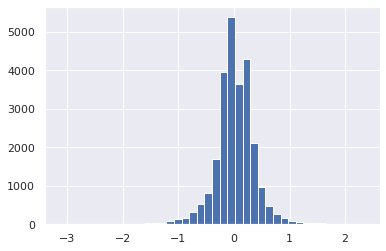

In [58]:
import matplotlib.pyplot as plt  #polarity score distribution
plt.hist(polarity_score,bins=40);

In [59]:
ind_sort=np.argsort(polarity_score)
ind_sort

array([18497, 24531, 19021, ..., 17646,  3610, 11288])

In [97]:
ind_negative=ind_sort[:25]
ind_positive=ind_sort[-1:-26:-1]

In [106]:
top_501=[]
top_502=[]
ind_positive=ind_sort[:25]
ind_negative=ind_sort[::-1][:25]
for i in range(25):
    top_501.append(ind_positive[i])
    top_502.append(ind_negative[i])
    

In [107]:
top_503=top_501+top_502

In [108]:
top_50=[]
for i in top_503:
    vect=model[-2].get_feature_names()[i]
    top_50.append(vect)

In [109]:
grader.score.nlp__most_polar(top_50)

Your score: 1.000


*Copyright &copy; 2021 WorldQuant University. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*